In [95]:
from collections import defaultdict
from datasets import load_dataset
import random
from datasets import Dataset
from datasets import DatasetDict
import torch
import json
from torch.utils.data import DataLoader
from pprint import pprint
import torch
from tqdm import tqdm
from transformers import BertTokenizer, DataCollatorWithPadding
import numpy as np

# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', force_download=False)
from transformers import BertForMaskedLM


In [96]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print(device)
MAX_LENGTH = 512
oracle = 2 # 0: no oracle; 1 hint; 2 mask
model_path = "./bert_finetuned/bert_finetuned_0_oracle_mask/"

# Define a function to process each example
def process_example(example):
    # Split the example into IN and OUT parts, and remove the labels
    text = example['text']
    parts = text.split('OUT:')
    in_part = parts[0].replace('IN:', '').strip()
    out_part = parts[1].strip() if len(parts) > 1 else ''
    return {'input': in_part, 'output': out_part}

datasets = load_dataset(
    'text', 
    data_files={'train': 'data/length_split/tasks_train_length.txt',
                'test': 'data/length_split/tasks_test_length.txt'})

datasets['train'] = datasets['train'].map(process_example)
datasets['test'] = datasets['test'].map(process_example)
# Display the processed dataset
print(datasets, datasets['train'][0])



cuda:0
DatasetDict({
    train: Dataset({
        features: ['text', 'input', 'output'],
        num_rows: 16990
    })
    test: Dataset({
        features: ['text', 'input', 'output'],
        num_rows: 3920
    })
}) {'text': 'IN: walk OUT: I_WALK', 'input': 'walk', 'output': 'I_WALK'}


In [97]:

# model = BertForMaskedLM.from_pretrained(model_path, force_download=False)
model = BertForMaskedLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
)
tokenizer = BertTokenizer.from_pretrained(model_path)

def tokenize_function(example):
    inputs = dict()
    input_str = []
    output_str = []
    if oracle == 1:
        input_str = [example["input"][id] + " [hint: target sequence length:"+str(len(tokenizer.tokenize(example["output"][id])))+"] "+ 
                        tokenizer.sep_token + (' ' + tokenizer.mask_token) * MAX_LENGTH for id in range(len(example["input"]))]
        output_str = [example["input"][id] +  " [hint: target sequence length:"+str(len(tokenizer.tokenize(example["output"][id])))+"] "+ 
                        tokenizer.sep_token + example["output"][id] + (' ' + tokenizer.sep_token) * MAX_LENGTH for id in range(len(example["input"]))]
    elif oracle == 2:
        for id in range(len(example["input"])):
            mask_tokens = (' ' + tokenizer.mask_token) * len(tokenizer.tokenize(example["output"][id]))
            input_str.append (example["input"][id] + tokenizer.sep_token + mask_tokens + (' ' + tokenizer.sep_token) * MAX_LENGTH)
            output_str.append(example["input"][id] + tokenizer.sep_token + example["output"][id] + (' ' + tokenizer.sep_token) * MAX_LENGTH)
        # print(input_str[0])
        # print(output_str[0])
    else:
        input_str = [example["input"][id] + tokenizer.sep_token + (' ' + tokenizer.mask_token) * MAX_LENGTH for id in range(len(example["input"]))]
        output_str = [example["input"][id] + tokenizer.sep_token + example["output"][id] + (' ' + tokenizer.sep_token) * MAX_LENGTH for id in range(len(example["input"]))]

    input_tokens = tokenizer(input_str, 
                            return_tensors='pt',
                            padding=True,
                            truncation=True,
                            max_length=MAX_LENGTH)
    output_tokens = tokenizer(output_str, 
                            return_tensors='pt',
                            padding=True,
                            truncation=True,
                            max_length=MAX_LENGTH)
    # print(input_str[0])
    # print(output_str[0])
    inputs.update(input_tokens)
    inputs['labels'] = output_tokens['input_ids']
    for idx in range(len(inputs['labels'])):
        for i in range(len(inputs['labels'][idx])):
            sep = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
            if inputs['labels'][idx][i] != sep:
                inputs['labels'][idx][i] = -100
            else:
                inputs['labels'][idx][i] = -100
                break
    # print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
    # print(tokenizer.convert_ids_to_tokens(inputs['labels'][0]))

    return inputs

In [98]:
tokenized_datasets = dict()
tokenized_datasets['train'] = datasets['train']
tokenized_datasets['test'] = datasets['test'].map(tokenize_function, 
                                                  batched=True, 
                                                  remove_columns=['text', 'input', 'output'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length=512, padding=True)


Map:   0%|          | 0/3920 [00:00<?, ? examples/s]

In [99]:


def calculate_accuracies(predictions, targets, input_lengths, label_lengths):
    """
    Calculate token-wise accuracy, sequence-wise accuracy, and additional accuracies:
        1. Token-level accuracy w.r.t. input sequence length
        2. Token-level accuracy w.r.t. label sequence length
        3. Sentence-level accuracy w.r.t. input sequence length
        4. Sentence-level accuracy w.r.t. label sequence length

    Args:
        predictions (list[list]): List of predicted token sequences.
        targets (list[list]): List of target token sequences.
        input_lengths (list[int]): Lengths of input sequences.
        label_lengths (list[int]): Lengths of label sequences.

    Returns:
        dict: A dictionary containing all calculated accuracies.
    """
    # Ensure predictions and targets are the same length
    assert len(predictions) == len(targets), "Predictions and targets must have the same number of sequences."
    assert len(predictions) == len(input_lengths) == len(label_lengths), \
        "Input lengths and label lengths must match the number of sequences."

    total_tokens = 0
    correct_tokens = 0
    correct_sequences = 0

    token_accuracy_wrt_input_length = defaultdict(list)
    token_accuracy_wrt_label_length = defaultdict(list)
    sequence_accuracy_wrt_input_length = defaultdict(list)
    sequence_accuracy_wrt_label_length = defaultdict(list)

    for idx, (pred_seq, target_seq, input_len, label_len) in enumerate(zip(predictions, targets, input_lengths, label_lengths)):
        # Ensure sequences are the same length
        assert len(pred_seq) == len(target_seq), "Each prediction and target sequence must have the same length."
        
        # Token-wise comparison
        sequence_correct = True
        token_correct_count = 0
        for pred_token, target_token in zip(pred_seq, target_seq):
            if pred_token == target_token:
                correct_tokens += 1
                token_correct_count += 1
            else:
                sequence_correct = False
        total_tokens += len(target_seq)

        # Sequence-level accuracy
        if sequence_correct:
            correct_sequences += 1

        # Accumulate token-level accuracy w.r.t input and label sequence length
        token_accuracy_wrt_input_length[input_len].append(token_correct_count / label_len)
        token_accuracy_wrt_label_length[label_len].append(token_correct_count / label_len)

        # Accumulate sequence-level accuracy w.r.t input and label sequence length
        sequence_accuracy_wrt_input_length[input_len].append(1 if sequence_correct else 0)
        sequence_accuracy_wrt_label_length[label_len].append(1 if sequence_correct else 0)

    # Aggregate results
    def aggregate_accuracy(data_dict):
        return {key: sum(values) / len(values) for key, values in data_dict.items()}

    aggregated_token_accuracy_input = aggregate_accuracy(token_accuracy_wrt_input_length)
    aggregated_token_accuracy_label = aggregate_accuracy(token_accuracy_wrt_label_length)
    aggregated_sequence_accuracy_input = aggregate_accuracy(sequence_accuracy_wrt_input_length)
    aggregated_sequence_accuracy_label = aggregate_accuracy(sequence_accuracy_wrt_label_length)

    # Calculate overall accuracies
    token_wise_accuracy = correct_tokens / total_tokens
    sequence_wise_accuracy = correct_sequences / len(targets)

    return {
        "token_wise_accuracy": token_wise_accuracy,
        "sequence_wise_accuracy": sequence_wise_accuracy,
        "token_accuracy_wrt_input_length": aggregated_token_accuracy_input,
        "token_accuracy_wrt_label_length": aggregated_token_accuracy_label,
        "sequence_accuracy_wrt_input_length": aggregated_sequence_accuracy_input,
        "sequence_accuracy_wrt_label_length": aggregated_sequence_accuracy_label
    }



def convert_string(source_string):
    # Split the string into tokens based on spaces
    tokens = source_string.split()
    # Initialize an empty list to hold the combined words
    combined_words = []
    while len(tokens) > 0:
        popped_token = tokens.pop(0)
        if popped_token != '_':
            combined_words.append(popped_token)
        elif len(tokens) > 0 and len(combined_words) > 0:
            new_word = combined_words.pop(-1) + popped_token + tokens.pop(0)
            combined_words.append(new_word)
    return combined_words


In [100]:
scan_vocab = []
with open("scan_vocabulary.json") as f:
    scan_vocab = json.load(f)
print(scan_vocab)
# Select ids and tokens with capital letters
selected_ids_tokens = {
    'ids': [],
    'tokens': []
}

for idx, token in zip(scan_vocab['ids'], scan_vocab['tokens']):
    if any(char.isupper() or char == '_' for char in token):  # Check for capital letters
        selected_ids_tokens['ids'].append(idx)
        selected_ids_tokens['tokens'].append(token)

print(selected_ids_tokens)

{'ids': [3714, 1286, 22027, 1170, 146, 147, 149, 1942, 155, 157, 5152, 1440, 1576, 168, 2346, 2101, 1213, 14663, 2249, 1105, 25810, 10835, 2647, 1885, 22751, 18784, 19556, 101, 102, 103, 27370, 2162, 3059, 1268, 23413, 24438, 2428], 'tokens': ['opposite', 'left', '##OK', 'after', 'I', 'J', 'L', '##T', 'R', 'T', 'jump', 'look', 'run', '_', '##O', '##P', 'around', '##EF', '##N', 'and', '##UM', '##rice', 'walk', 'turn', 'WA', '##HT', '##UR', '[CLS]', '[SEP]', '[MASK]', '##UN', '##L', 'twice', 'right', '##IG', 'th', '##K']}
{'ids': [22027, 146, 147, 149, 1942, 155, 157, 168, 2346, 2101, 14663, 2249, 25810, 22751, 18784, 19556, 101, 102, 103, 27370, 2162, 23413, 2428], 'tokens': ['##OK', 'I', 'J', 'L', '##T', 'R', 'T', '_', '##O', '##P', '##EF', '##N', '##UM', 'WA', '##HT', '##UR', '[CLS]', '[SEP]', '[MASK]', '##UN', '##L', '##IG', '##K']}


In [101]:
# Evaluation
def evaluation(dataset, model, batch_size, tokenizer):
    data_loader = DataLoader(dataset, # tokenized_datasets['test'].with_format("torch") 
                             batch_size=batch_size, 
                             shuffle=False)
    targets = []
    predictions = []
    model.to(device)
    input_lengths = []
    outputs_logits = []
    labels = []
    label_span = []
    # print(model.device, device)
    with torch.no_grad():
        for data in tqdm(data_loader):
            for key in data:
                data[key] = data[key].to(model.device)
                # print(key, data[key].device)
            # Predict
            outputs = model(**data, return_dict=True)  
            # Greedy sampling
            prediction = outputs.logits.argmax(dim=-1)
            outputs_logits.append(outputs.logits.detach().cpu().softmax(dim=2)[:, :, selected_ids_tokens['ids']])
            print(outputs_logits[-1].shape)
            # Truncation according to the length of labels
            for batch_idx in range(len(data['labels'])):
                target = []
                pre = []
                indices = []
                input_len = len(tokenizer.decode(data['input_ids'][batch_idx].cpu().tolist(), 
                                skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True).split())
                input_lengths.append(input_len) 
                for i in range(len(data['labels'][batch_idx])):
                    if data['labels'][batch_idx][i] != -100:
                        sep = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
                        if data['labels'][batch_idx][i] == sep: # 102
                            # Convert BERT tokens into task specific tokens
                            target_seq = convert_string(tokenizer.decode(target, 
                                                        skip_special_tokens=True, 
                                                        clean_up_tokenization_spaces=True))
                            pre_seq = convert_string(tokenizer.decode(pre, 
                                                    skip_special_tokens=True, 
                                                    clean_up_tokenization_spaces=True))
                            if len(target_seq) > len(pre_seq):
                                pre_seq += [tokenizer.sep_token] * (len(target_seq) - len(pre_seq))
                            elif len(target_seq) < len(pre_seq):
                                pre_seq = pre_seq[:len(target_seq)]
                            assert len(target_seq) == len(pre_seq), \
                                "Each prediction and target sequence must have the same length."
                            targets.append(target_seq)
                            predictions.append(pre_seq)
                            labels.append(data['labels'][batch_idx].cpu())
                            label_span.append(indices)
                            break
                        target.append(data['labels'][batch_idx][i].cpu().item())
                        pre.append(prediction[batch_idx][i].cpu().item())     
                        indices.append(i)
            break
        label_lengths = [len(label_seq) for label_seq in targets]
        outputs_logits = torch.cat(outputs_logits, dim=0).tolist()
        labels = torch.stack(labels, dim=0).tolist()
    return {
        'acc': calculate_accuracies(predictions, targets, input_lengths, label_lengths),
        'outputs_logits': outputs_logits,
        'labels': labels,
        'label_span': label_span
    }

In [102]:
result_dict = evaluation(tokenized_datasets['test'].with_format("torch"), 
                     model, batch_size=1, tokenizer=tokenizer)


# Save to files
# torch.save(result_dict['outputs_logits'], "outputs_logits.pt")
# torch.save(result_dict['labels'], "labels.pt")
with open('acc_dict_with_oracle.json', 'w') as f:
    json.dump(result_dict, f, indent=4)
results = result_dict['acc']
print(results)

  0%|          | 0/3920 [00:00<?, ?it/s]

torch.Size([1, 512, 23])
{'token_wise_accuracy': 0.7083333333333334, 'sequence_wise_accuracy': 0.0, 'token_accuracy_wrt_input_length': {8: 0.7083333333333334}, 'token_accuracy_wrt_label_length': {24: 0.7083333333333334}, 'sequence_accuracy_wrt_input_length': {8: 0.0}, 'sequence_accuracy_wrt_label_length': {24: 0.0}}


In [103]:
result_dict['outputs_logits'] = np.array(result_dict['outputs_logits'])
result_dict['labels'] = np.array(result_dict['labels'])
result_dict['label_span'] = np.array(result_dict['label_span'])

result_dict['outputs_logits'].shape, result_dict['labels'].shape, result_dict['label_span'].shape

((1, 512, 23), (1, 512), (1, 156))

In [104]:
temp_ids = [result_dict['labels'][0][i] for i in result_dict['label_span'][0]]
print(" ".join(convert_string(tokenizer.decode(temp_ids, skip_special_tokens=True))))
len(convert_string(tokenizer.decode(temp_ids, skip_special_tokens=True)))

I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN


24

In [105]:
selected_elements = result_dict['outputs_logits'][:, list(result_dict['label_span'][0]), :]
selected_labels = result_dict['labels'][:, list(result_dict['label_span'][0])]
selected_elements.shape, selected_labels.shape

((1, 156, 23), (1, 156))

In [106]:
sum_prob = np.sum(selected_elements, axis=2)
print(sum_prob.shape, np.min(sum_prob)) # Flag 1
print(sum_prob)



(1, 156) 0.9976462477600965
[[1.         1.         1.00000008 1.00000022 1.00000023 1.00000001
  1.0000005  1.00000035 1.00000019 1.00000021 1.         1.00000024
  1.00000003 1.00000003 1.00000003 1.00000017 1.00000291 1.00000018
  1.00000257 1.00001507 1.00000013 1.00000156 1.00000227 1.00000001
  1.00000001 1.00000111 1.00000013 1.         1.00000001 1.00000001
  1.00000002 1.00000001 1.00000036 1.00000096 1.00000017 1.00000019
  1.00000024 1.00000003 1.00000003 1.00000054 1.00000006 1.0000001
  1.00000001 1.00000004 1.         1.00000078 1.00000005 1.00000015
  1.00000003 1.00000008 1.00000012 1.0000001  1.00000017 1.
  1.00000002 1.00000007 1.00000022 1.00000001 1.00000348 1.00000017
  1.00000016 1.00000015 1.         1.0000002  1.00000049 1.00000018
  1.00000004 1.00000004 1.00000005 1.00000024 1.00000001 1.000001
  1.00000023 1.00000054 1.0000003  1.00000003 1.00000079 1.00000163
  1.00000987 1.00000001 1.00000045 1.00000018 1.00002147 1.00000045
  1.00000111 1.0000062  1.00001

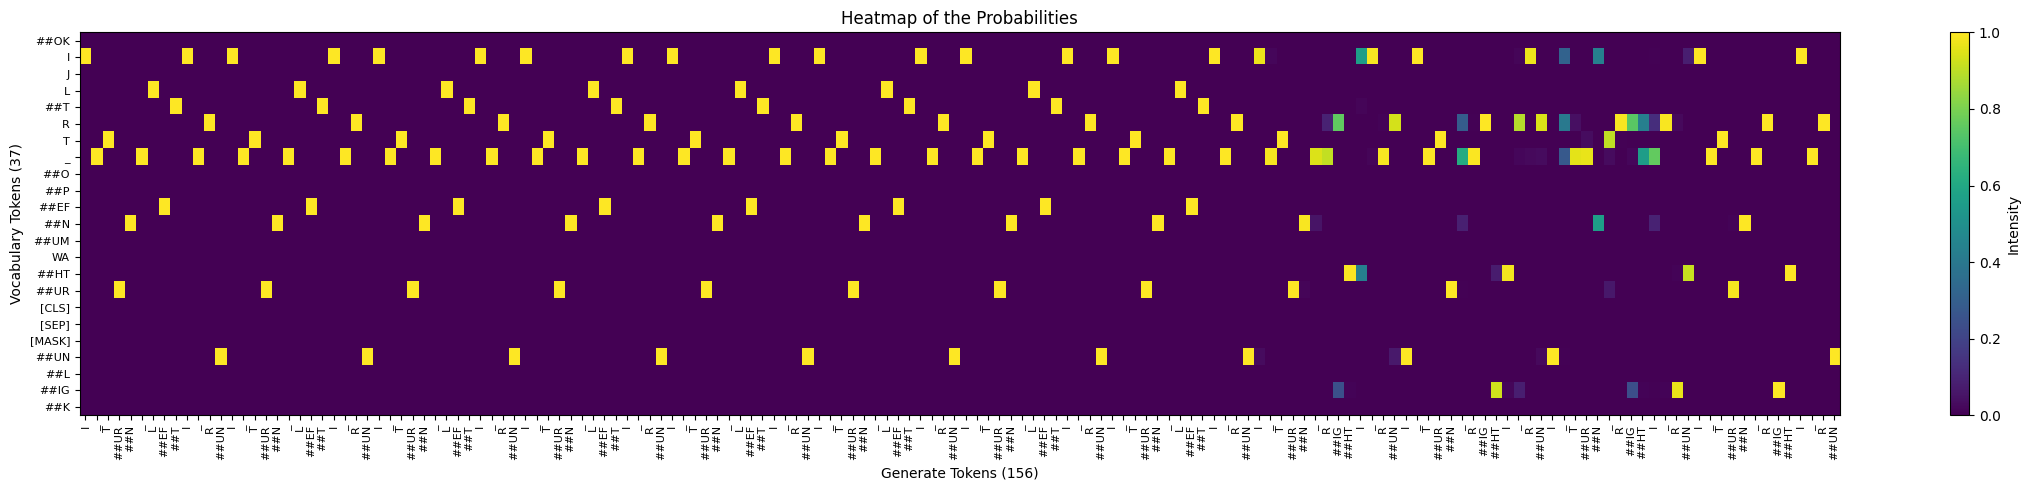

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for demonstration
# selected_elements = np.random.rand(1, 156, 37)  # Shape: (1, 156, 37)
# selected_labels = np.random.randint(0, 10, (1, 156))  # Shape: (1, 156)
# scan_vocab = {'tokens': [f'token_{i}' for i in range(37)]}  # Example vocabulary

# Extracting the data for plotting
heatmap_data = selected_elements[0]  # Shape: (156, 37)
x_labels = tokenizer.convert_ids_to_tokens(selected_labels[0])  # Shape: (156,)
y_labels = selected_ids_tokens['tokens']  # Shape: (37,)

# Create the heatmap
plt.figure(figsize=(23, 5))
plt.imshow(heatmap_data.T, aspect='auto', cmap='viridis', interpolation='nearest')

# Set the labels for the axes
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, fontsize=8)

# Add color bar
plt.colorbar(label="Intensity")

# Axis labels and title
plt.xlabel("Generate Tokens (156)")
plt.ylabel("Vocabulary Tokens (37)")
plt.title("Heatmap of the Probabilities")

# Display the heatmap
plt.tight_layout()
plt.savefig('Heatmap_of_the_Probabilities.pdf', bbox_inches='tight')
plt.show()
